In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import datetime

import pickle

import random

import torch.nn as nn

In [ ]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:

def window_array_overlap(array, window_size, overlap):
  """Transforme un array en entrée du VAE avec des fenêtres glissantes et avec/sans chevauchement.

  Args:
      array: Le array d'entrée en 1D.
      window_size: La taille de chaque fenêtre.
      overlap: Le nombre d'éléments de chevauchement entre les fenêtres.

  Returns:
      Un array 3D avec les fenêtres glissantes.
  """

  # Calcul du nombre de fenêtres
  num_windows = (len(array) - window_size) // (window_size - overlap) + 1
  #print(f'num_windows {num_windows}')

  # Création de l'array 3D
  windows = np.zeros((num_windows, window_size))

  # Génération des fenêtres glissantes avec chevauchement
  for i in range(num_windows):
    start = i * (window_size - overlap)
    end = start + window_size
    windows[i] = array[start:end]

  return windows



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 25 09:07:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   35C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/VAE model/df_3_freezer_normal.csv')
df2 = pd.read_csv('/content/drive/MyDrive/VAE model/df_6_freezer_normal.csv')
df4 = pd.read_csv('/content/drive/MyDrive/VAE model/house20_anotated.csv')

In [ ]:
df4.head(2)
df4 = df4[['unix','time','freezer','type_defaut_freezer']]

In [ ]:
# je dois standariser mes donné avant de les transformer en sequence
scaler = StandardScaler()

h3_normalized = scaler.fit_transform(df1[['freezer']])
h6_normalized = scaler.fit_transform(df2[['freezer']])

h20_norm = scaler.fit_transform(df4[['freezer']])

print(h20_norm.shape)


seq_h3 = window_array_overlap(h3_normalized.reshape(-1), 4032, 0)
seq_h6 = window_array_overlap(h6_normalized.reshape(-1), 4032, 0)

test_data_anotated = window_array_overlap(h20_norm.reshape(-1), 4032, 0)



train_data_normalized = np.concatenate((seq_h3, seq_h6), axis=0)

print(train_data_normalized.shape)
print(test_data_anotated.shape)




(4676401, 1)
(2205, 4032)
(1159, 4032)


In [ ]:
(np.array(df1['freezer'])).shape

(4573585,)

In [ ]:
# this part is for the anotation

# ici je met la fonction qui utilise les donné anoté et revoi les label
df4.head(3)
df4 = df4[['unix', 'freezer', 'type_defaut_freezer']]
list_anomaly = []
for i in df4['type_defaut_freezer'] :
    if (i ==1) or (i==2) :
        list_anomaly.append(1)
    else:
        list_anomaly.append(0)

df4['anomaly'] = list_anomaly
print(f'liste des des anomalies annoté est de taille : {len(list_anomaly)} et les valeur unique sont {np.unique(list_anomaly)}')




# Définition de la taille de la séquence
sequence_length = 4032
seuil = 10 #30%

# Fonction pour diviser le DataFrame en séquences et les labelliser
def create_sequences_and_labels(df3, sequence_length, seuil):
    sequences = []
    labels = []

    # Nombre total de séquences possibles
    num_sequences = len(df3) // sequence_length

    for i in range(num_sequences):
        # Sélectionner la séquence
        sequence = df3.iloc[i * sequence_length : (i + 1) * sequence_length]

        # Vérifier le nombre d'anomalies dans la séquence
        anomaly_count = sequence['anomaly'].sum()

        # Déterminer le label de la séquence
        label = 1 if anomaly_count >= seuil else 0

        # Ajouter la séquence et le label à la liste
        sequences.append(sequence['freezer'].values)
        labels.append(label)

    return np.array(sequences), np.array(labels)


sequence_test, labesl_test = create_sequences_and_labels(df4, sequence_length, seuil)

print(len(labesl_test))

liste des des anomalies annoté est de taille : 4676401 et les valeur unique sont [0 1]
1159


In [ ]:
# division en sequence de 1000, don't forget sampling_factor
seq_h3 = window_array_overlap(np.array(df1['freezer']), 4032, 0)
seq_h6 = window_array_overlap(np.array(df2['freezer']), 4032, 0)

seq_h20_anotated = window_array_overlap(np.array(df4['freezer']), 4032, 0)


In [ ]:
scaler = StandardScaler()
seq_h3_normalized = scaler.fit_transform(seq_h3)
seq_h6_normalized = scaler.fit_transform(seq_h6)

test_data_anotated = scaler.fit_transform(seq_h20_anotated)

train_data_normalized = np.concatenate((seq_h3_normalized, seq_h6_normalized), axis=0)
print(train_data_normalized.shape)
print(test_data_anotated.shape)




(2205, 4032)
(1159, 4032)


In [ ]:
x_train = np.concatenate((seq_h3, seq_h6), axis=0)
print(x_train.shape)

(2205, 4032)


In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [ ]:
multiples_de_64 = [i for i in range(0, 5000) if i % 64 == 0]


In [ ]:
train_data_normalized = scaler.transform(x_train)

test_data_anotated = scaler.transform(seq_h20_anotated)

In [ ]:
test_data_anotated.std()

0.9999999999999998

In [ ]:
4654645/ 8000

581.830625

In [ ]:
train_data_normalized.shape, test_data_anotated.shape

((2205, 4032), (1159, 4032))

In [ ]:
np.std(train_data_normalized)

1.0001090667728678

### L'architecture du VAE

In [ ]:
((8000 + 2 -1 *(2) -1)/2)+1

4000.5

In [ ]:
128/2

64.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1), # on chanel, seq size of : 900
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1)
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * (input_size // (2**6)), latent_dim)
        #self.fc_mu = nn.Linear(128 * (125), latent_dim)
        #self.fc_mu = nn.Linear(1920, 128)
        #
        self.fc_logvar = nn.Linear(64 * (input_size // (2**6)), latent_dim)
        #self.fc_logvar = nn.Linear(128 * (125), latent_dim)
        #self.fc_logvar = nn.Linear(1920, 128)


        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 64 * (input_size // (2**6)))
        #self.decoder_fc = nn.Linear(latent_dim, 128 * (125))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose1d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Dropout(p=0.1)

            # ajout d'une chouche pour adapter l'architecture a une séquence de taille 900


            #nn.Conv1d(in_channels=1, out_channels=1, kernel_size=60, stride=1, padding=0)

        )

    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 64, -1) # reshape for ConvTranspose1d
        x = self.decoder_conv(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return  x_recon, mu, logvar


In [ ]:
8000 // (2**6)

125

In [ ]:
x_train.shape

NameError: name 'x_train' is not defined

In [ ]:
from torchsummary import summary

In [ ]:
# Convert the training data to PyTorch tensors
X_train = torch.from_numpy(train_data_normalized)


input_size = train_data_normalized.shape[1] #900 #len(xscaled_windows)  # Taille de l'entrée (séquence de longueur 1000), maybe i should change this one
latent_dim = 128  # 125 ? non

# Create the autoencoder model and optimizer
vae = VAE(input_size, latent_dim)



In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
# Define the loss function
# nn.MSELoss(reduction='none')

criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='none')

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

VAE(
  (encoder_conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ELU(alpha=1.0)
    (15): Dropout(p=0.1, inplace=False)
    (16): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1

In [ ]:
# Create a DataLoader to handle batching of the training data
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size
)

In [ ]:
(next(iter(train_loader))).shape

torch.Size([32, 4032])

In [ ]:
 X_train.shape

torch.Size([2205, 4032])

In [ ]:
# Training loop
num_epochs = 500
list_loss = []
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device

        data = data.to(device).float()  #
        #print(data.shape)

        data = torch.unsqueeze(data, 1)  # [32, 900] > [32, 1, 900] / 32, 900, 1
        #data = data.permute(0, 2, 1)
        #print(data.shape)

        x_recon, mu, logvar = vae(data)
        #print(f'x_recon shape {x_recon.shape}')

        # Compute the loss and perform backpropagation

        #print(x_recon.shape)
        #print(x_recon.shape)

        loss = criterion(x_recon, data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: reconstruction_error={:.6f}".format(epoch + 1, num_epochs, epoch_loss)
    )
    list_loss.append(epoch_loss)



Epoch 1/500: reconstruction_error=0.873774
Epoch 2/500: reconstruction_error=0.613153
Epoch 3/500: reconstruction_error=0.568177
Epoch 4/500: reconstruction_error=0.545747
Epoch 5/500: reconstruction_error=0.541525
Epoch 6/500: reconstruction_error=0.515128
Epoch 7/500: reconstruction_error=0.503620
Epoch 8/500: reconstruction_error=0.499513
Epoch 9/500: reconstruction_error=0.488552
Epoch 10/500: reconstruction_error=0.482284
Epoch 11/500: reconstruction_error=0.476589
Epoch 12/500: reconstruction_error=0.483122
Epoch 13/500: reconstruction_error=0.479717
Epoch 14/500: reconstruction_error=0.464635
Epoch 15/500: reconstruction_error=0.461558
Epoch 16/500: reconstruction_error=0.452843
Epoch 17/500: reconstruction_error=0.449931
Epoch 18/500: reconstruction_error=0.446546
Epoch 19/500: reconstruction_error=0.442261
Epoch 20/500: reconstruction_error=0.438075
Epoch 21/500: reconstruction_error=0.433795
Epoch 22/500: reconstruction_error=0.430891
Epoch 23/500: reconstruction_error=0.4266

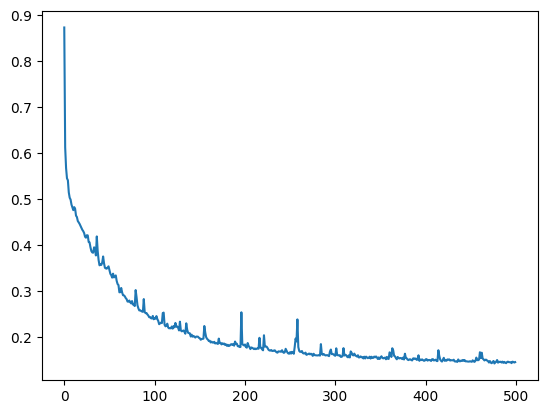

In [ ]:
plt.plot(list_loss)

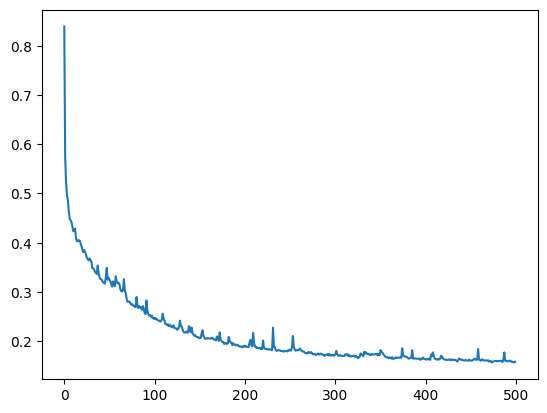

In [ ]:
plt.plot(list_loss)

In [ ]:
treshold = np.mean(list_loss) + 2*np.std(list_loss)
print(treshold)

0.3903096460858066


### test sur les données anoté direct pour calculé l'erreur et voir si c'est bien ou pas

In [ ]:
test = test_data_anotated  #
test = torch.from_numpy(test)
test = test.unsqueeze(1)  # Ajouter une dimension de canal, donc shape devient (583, 1, 8000)
test = test.to(device).float()

In [ ]:
test = test.to(device).float()

In [ ]:
test.unsqueeze(1).shape

torch.Size([1159, 1, 1, 4032])

In [ ]:
criterion2 = nn.MSELoss(reduction='none')

In [ ]:
# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon, mu, logvar = vae(test)

    # Calculer la perte de reconstruction
    recon_loss = criterion(x_recon, test)
    recon_loss_each_seq = criterion2(x_recon, test)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss)
    print(recon_loss_each_seq)


tensor(0.2467, device='cuda:0')
tensor([[[1.1969e-01, 1.2276e-01, 1.1188e-01,  ..., 8.1221e-02,
          1.0716e-01, 3.0602e-01]],

        [[1.3047e-01, 1.3354e-01, 1.2288e-01,  ..., 1.7292e-01,
          1.8976e-01, 3.1984e-01]],

        [[1.2914e-01, 1.2875e-01, 1.3186e-01,  ..., 2.0858e-02,
          2.1645e-02, 4.4517e-02]],

        ...,

        [[2.3758e-02, 7.6737e-04, 4.6211e-04,  ..., 2.9609e-01,
          3.1024e-01, 4.3465e-01]],

        [[1.3315e-01, 1.2736e-01, 1.1548e-01,  ..., 6.7066e-02,
          5.3066e-02, 1.6402e-01]],

        [[1.2453e-01, 1.3671e-01, 1.1235e-01,  ..., 1.1629e+00,
          1.2037e+00, 9.7486e-01]]], device='cuda:0')


In [ ]:
treshold

0.39861503458775704

In [ ]:
# here, i have the reconstruction error of all my test dat, also a matrix of all reconstrucition on each point, what i need is to get the label of each sequence on our test data, 30% 1 => lablel = 1, donne labesl_test
tensor_squeezed = recon_loss_each_seq.squeeze(1)
print(f'tensor_squeezed {tensor_squeezed.shape}')


tensor_squeezed_cpu = tensor_squeezed.cpu()



numpy_array = tensor_squeezed_cpu.numpy()
print(numpy_array.shape)


predicter_error =[]

for x in numpy_array:
    predicter_error.append(x.mean())

predicted = np.where(np.array(predicter_error) > treshold, 1, 0)

tensor_squeezed torch.Size([1159, 4032])
(1159, 4032)


In [ ]:
# labesl_test
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

accuracy = accuracy_score(labesl_test, predicted)
recall = recall_score(labesl_test, predicted, pos_label=1)
f1 = f1_score(labesl_test, predicted, pos_label=1)

precision = precision_score(labesl_test, predicted, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.6920
Recall: 0.1923
F1-score: 0.0775
Precision: 0.0485


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labesl_test, predicted)
print(cm)

[[787 294]
 [ 63  15]]


In [ ]:
# les résultats des metrics
test = test_data_anotated
test = torch.from_numpy(test)
test = test.unsqueeze(1)
test = test.to(device).float()
test = test.float()

criterion2 = nn.MSELoss(reduction='none')

# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon = vae(test)

    # Calculer la perte de reconstruction
    recon_loss = criterion(x_recon, test)
    recon_loss_each_seq = criterion2(x_recon, test)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss)
    print(recon_loss_each_seq)


# here, i have the reconstruction error of all my test dat, also a matrix of all reconstrucition on each point, what i need is to get the label of each sequence on our test data, 30% 1 => lablel = 1, donne labesl_test
tensor_squeezed = recon_loss_each_seq.squeeze(1)
print(f'tensor_squeezed {tensor_squeezed.shape}')


tensor_squeezed_cpu = tensor_squeezed.cpu()



numpy_array = tensor_squeezed_cpu.numpy()
print(numpy_array.shape)


predicter_error =[]

for x in numpy_array:
    predicter_error.append(x.mean())

predicted = np.where(np.array(predicter_error) > threshold, 1, 0)

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# labesl_test
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

accuracy = accuracy_score(labesl_test, predicted)
recall = recall_score(labesl_test, predicted, pos_label=1)
f1 = f1_score(labesl_test, predicted, pos_label=1)

precision = precision_score(labesl_test, predicted, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

In [ ]:
x_recon.shape

torch.Size([1159, 1, 4032])

In [ ]:
# i need to add, the part where te anotated part for df4(anotated one) so that i can. compute the metrics

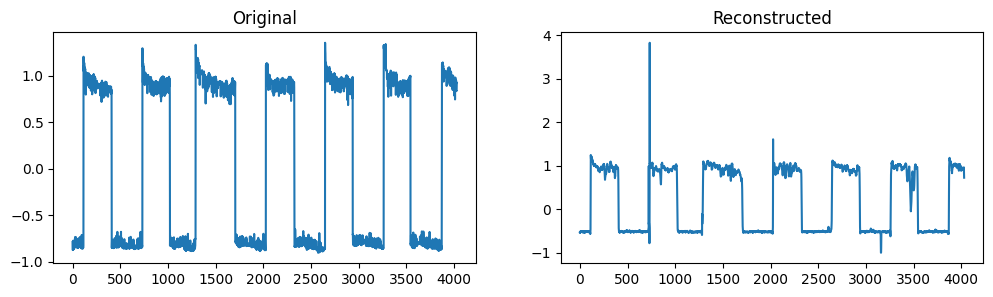

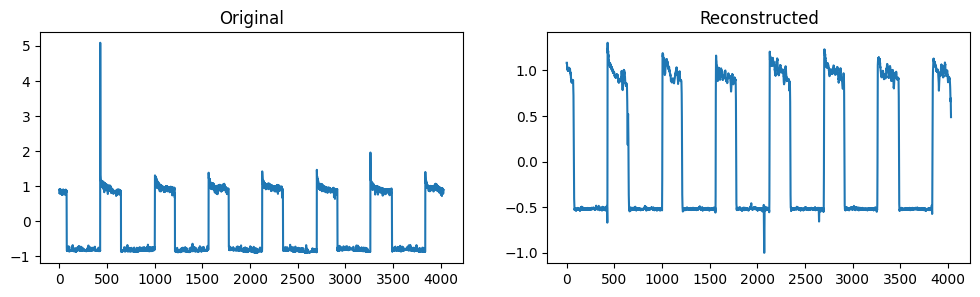

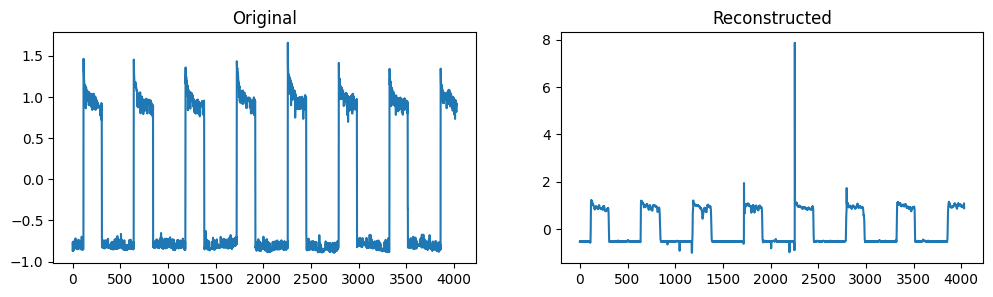

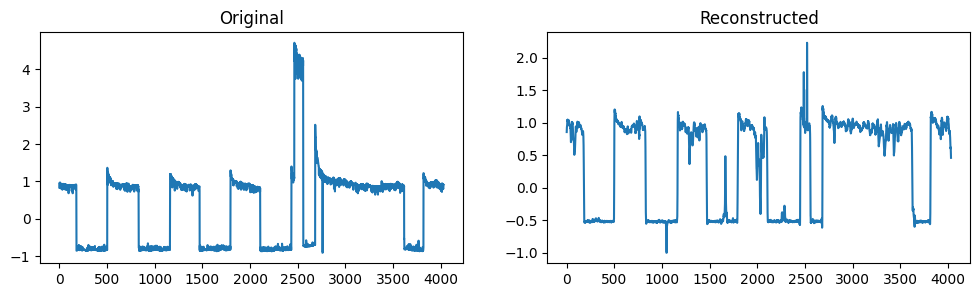

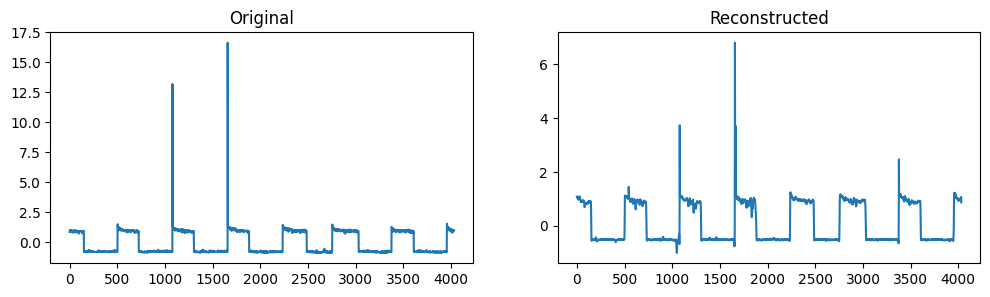

In [ ]:
# Sélectionner quelques exemples aléatoires
num_examples = 5
indices = torch.randint(0, test.size(0), (num_examples,))

for i, idx in enumerate(indices):
    original = test[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.plot(reconstructed)
    plt.title('Reconstructed')
    plt.show()

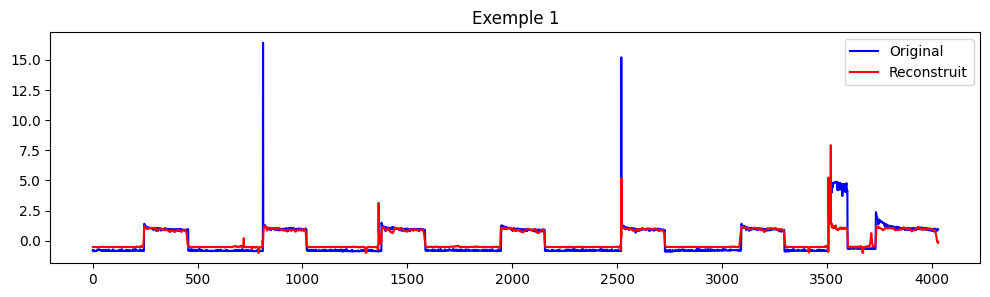

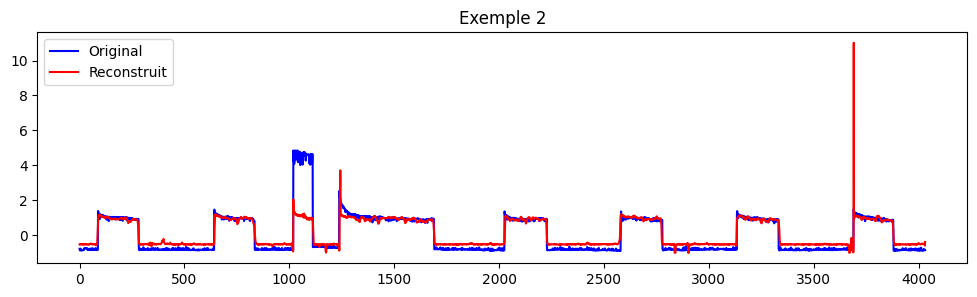

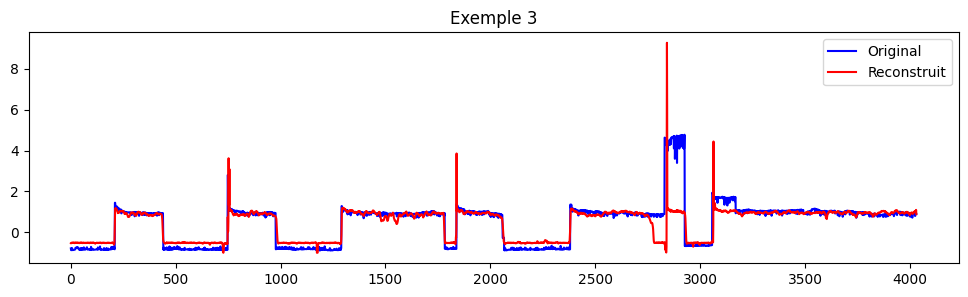

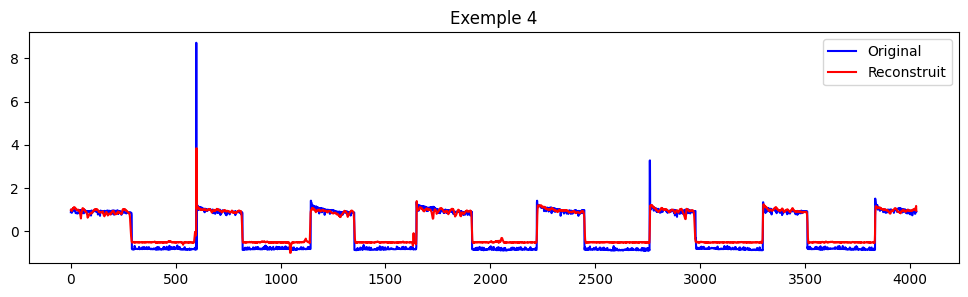

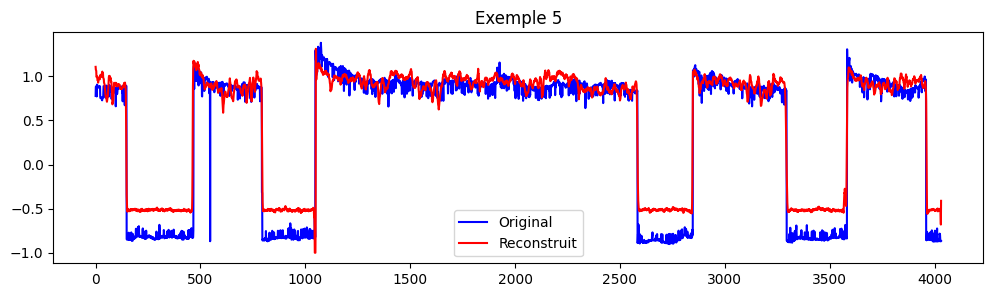

In [ ]:
num_examples = 5
indices = torch.randint(0, test.size(0), (num_examples,))

for i, idx in enumerate(indices):
    original = test[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    plt.figure(figsize=(12, 3))
    plt.plot(original, label='Original', color='blue')
    plt.plot(reconstructed, label='Reconstruit', color='red')
    plt.title(f'Exemple {i + 1}')
    plt.legend()
    plt.show()

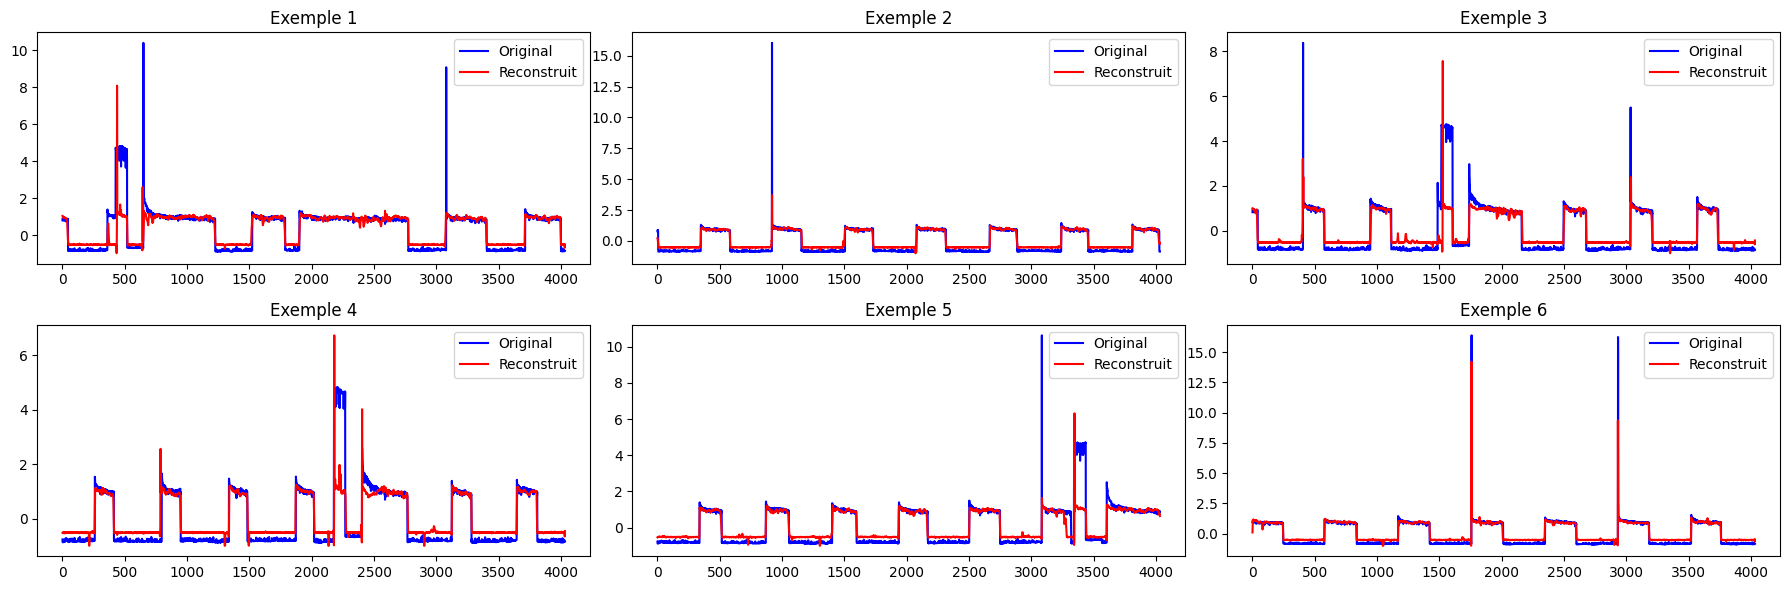

In [ ]:
num_examples = 6
indices = torch.randint(0, test.size(0), (num_examples,))

# Créer une figure avec 2 lignes et 3 colonnes
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

# Itérer sur les indices et remplir chaque sous-graphe
for i, idx in enumerate(indices):
    original = test[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    ax = axs[i // 3, i % 3]  # Déterminer la position du subplot
    ax.plot(original, label='Original', color='blue')
    ax.plot(reconstructed, label='Reconstruit', color='red')
    ax.set_title(f'Exemple {i + 1}')
    ax.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

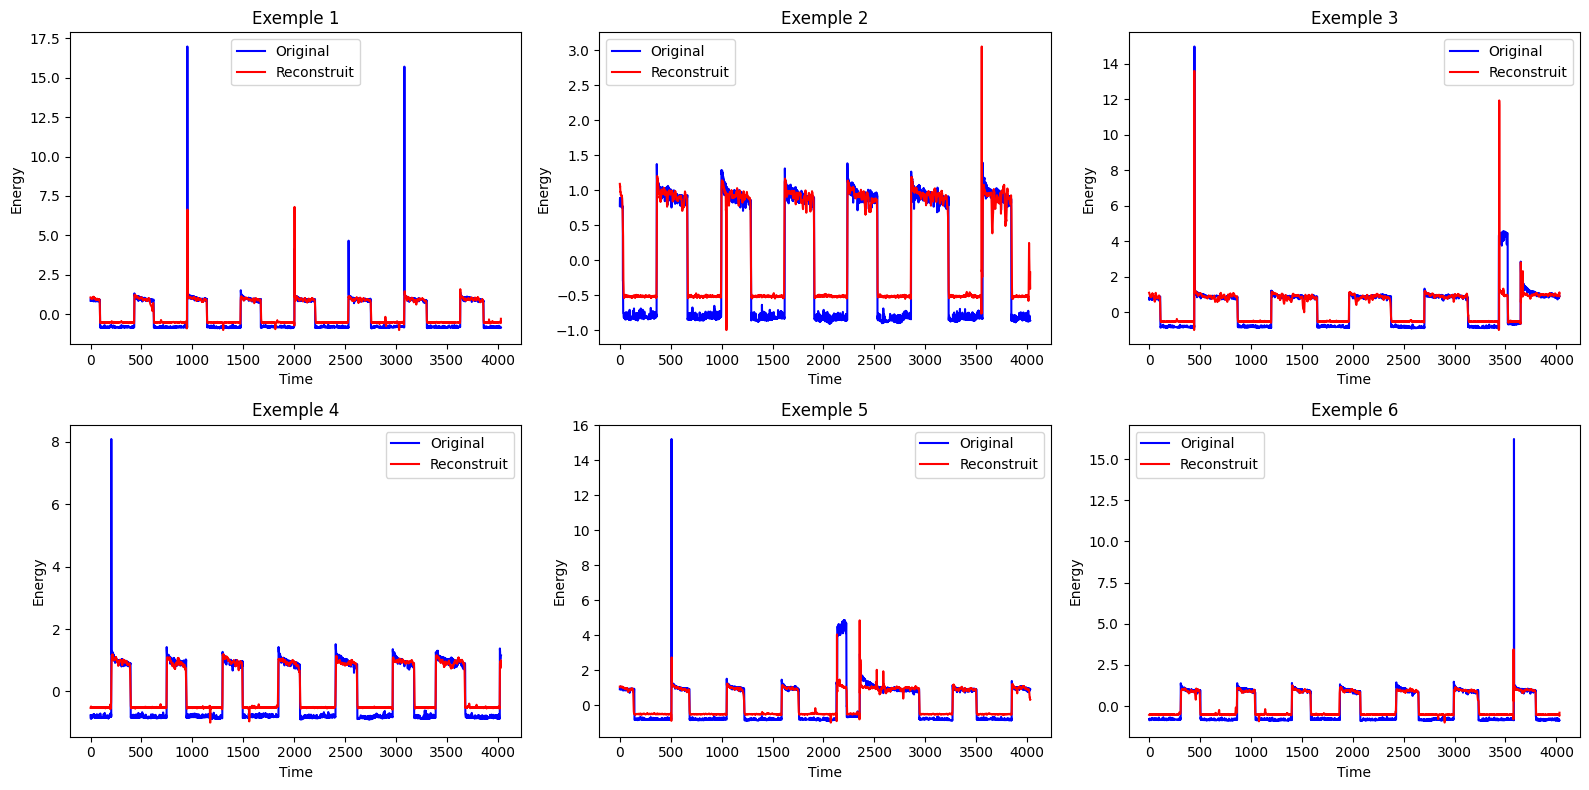

In [ ]:
num_examples = 6
indices = torch.randint(0, test.size(0), (num_examples,))

# Créer une figure avec 2 lignes et 3 colonnes
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Itérer sur les indices et remplir chaque sous-graphe
for i, idx in enumerate(indices):
    original = test[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    ax = axs[i // 3, i % 3]  # Déterminer la position du subplot
    ax.plot(original, label='Original', color='blue')
    ax.plot(reconstructed, label='Reconstruit', color='red')
    ax.set_title(f'Exemple {i + 1}')
    ax.set_xlabel('Time')  # Titre de l'axe x
    ax.set_ylabel('Energy')  # Titre de l'axe y
    ax.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/VAE model/vae_expérieementation/model_vae_seq4032_500_test_20.pth"
torch.save(vae.state_dict(), model_path)

In [ ]:
reconstructed.shape, x_recon.shape

((4032,), torch.Size([1159, 1, 4032]))

In [ ]:
flattened_tensor = x_recon.view(-1)
print(flattened_tensor.shape)
np_reconstruit = flattened_tensor.cpu().numpy()
print(np_reconstruit.shape)

torch.Size([4673088])
(4673088,)


In [ ]:
np_reconstruit[1:4]

array([-0.43061113, -0.491768  , -0.4858206 ], dtype=float32)

In [ ]:
df4.head()

,unix,time,freezer,type_defaut_freezer
0,1395360000,2014-03-21 00:00:00,2.0,0
1,1395360008,2014-03-21 00:00:08,2.0,0
2,1395360016,2014-03-21 00:00:16,2.0,0
3,1395360024,2014-03-21 00:00:24,2.0,0
4,1395360032,2014-03-21 00:00:32,2.0,0


In [ ]:
(h20_norm.reshape(-1)).shape

(4676401,)

In [ ]:
4676401 + 3313

4679714

In [ ]:
combined_array = np.concatenate((np_reconstruit, np.full(3313, np.nan)))
print(combined_array.shape)

(4676401,)


In [ ]:
# ici je dois avoir ici, est deux liste en plus une normaliser et une autre recontruite, comme ca je pourais faire mes test tranquilement
df4['freezer_standarisé'] = h20_norm.reshape(-1)
df4['freezer_reconstruit'] = combined_array

In [ ]:
combined_array

array([-0.50735152, -0.50446314, -0.51687682, ...,         nan,
               nan,         nan])

In [ ]:
len(df4), len(h20_norm)

4676401

In [ ]:
df4.head(2)

,unix,time,freezer,type_defaut_freezer,freezer_standarisé,freezer_reconstruit
0,1395360000,2014-03-21 00:00:00,2.0,0,-0.812939,-0.507352
1,1395360008,2014-03-21 00:00:08,2.0,0,-0.812939,-0.504463


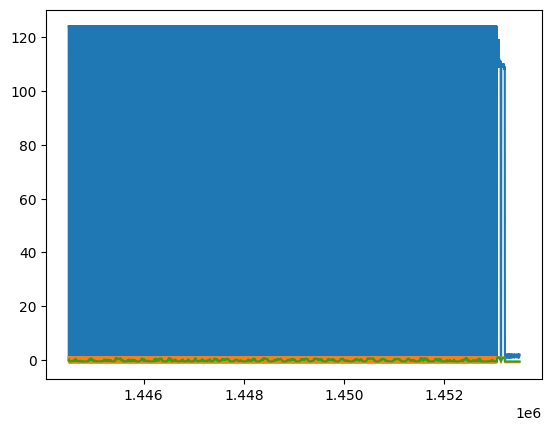

In [ ]:
# test sur des séquence d'anomalie

plt.plot(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer'])

plt.plot(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer_standarisé'])

plt.plot(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer_reconstruit'])





In [ ]:
liste_frequent anomaly

array([-0.03904516,  0.00059491,  0.03897242, ..., -0.51587737,
       -0.51453978, -0.51136082])

In [ ]:
df4.head()

,unix,freezer,type_defaut_freezer,anomaly
0,1395360000,2.0,0,0
1,1395360008,2.0,0,0
2,1395360016,2.0,0,0
3,1395360024,2.0,0,0
4,1395360032,2.0,0,0


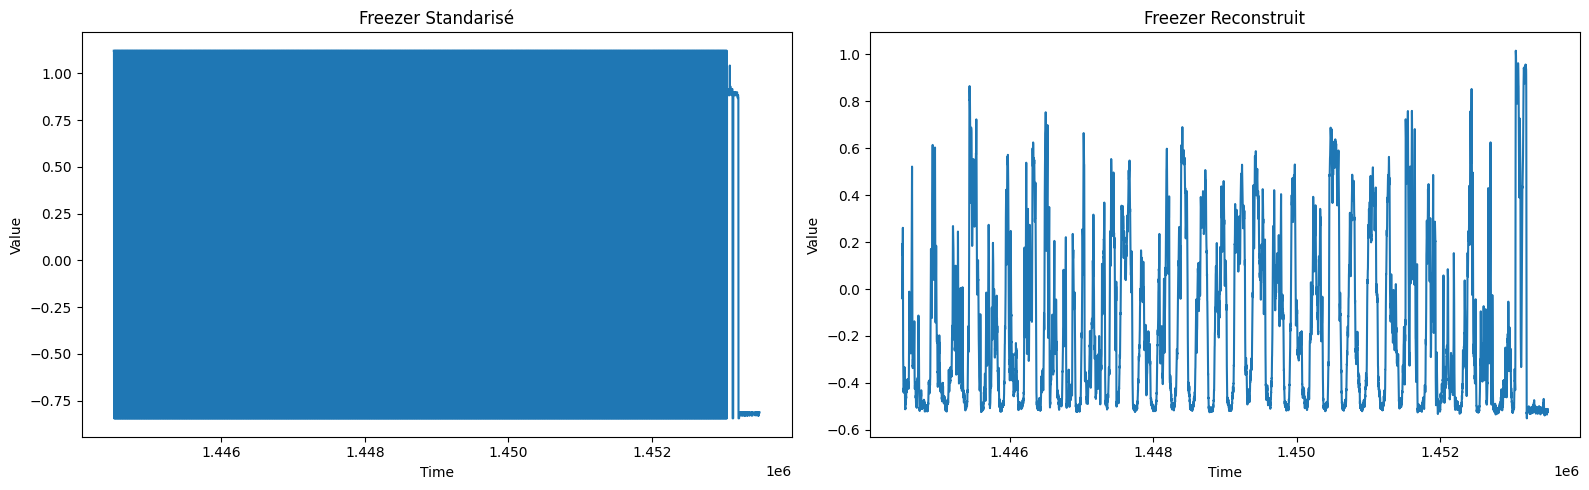

In [ ]:
import matplotlib.pyplot as plt

# Créer une figure avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 2, figsize=(16, 5))


# Tracé du freezer standardisé
axs[0].plot(df4[(df4['time'] >= '2014-08-01 18:00:00') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer_standarisé'])
axs[0].set_title('Original')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')

# Tracé du freezer reconstruit
axs[1].plot(df4[(df4['time'] >= '2014-08-01 18:00:00') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer_reconstruit'])
axs[1].set_title('Reconstruit')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Afficher les graphiques
plt.show()


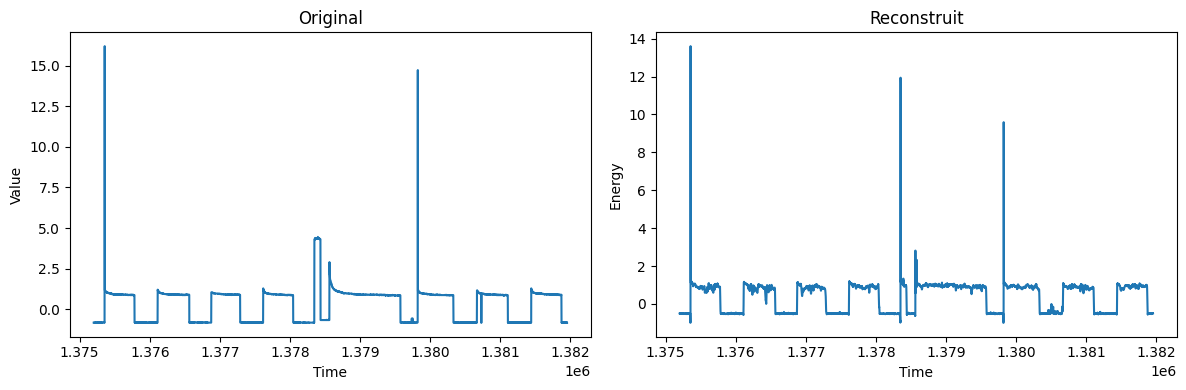

In [ ]:
import matplotlib.pyplot as plt

# Créer une figure avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))


# Tracé du freezer standardisé
axs[0].plot(df4[(df4['time'] >= '2014-07-26 08:00:00') & (df4['time'] <= '2014-07-26 23:00:08')]['freezer_standarisé'])
axs[0].set_title('Original')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')

# Tracé du freezer reconstruit
axs[1].plot(df4[(df4['time'] >= '2014-07-26 08:00:00') & (df4['time'] <= '2014-07-26 23:00:08')]['freezer_reconstruit'])
axs[1].set_title('Reconstruit')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Energy')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Afficher les graphiques
plt.show()


In [ ]:
1159 * 4032

4673088

In [ ]:

len(reconstructed)

4032

In [ ]:
df4.head(2)

,unix,time,freezer,type_defaut_freezer
0,1395360000,2014-03-21 00:00:00,2.0,0
1,1395360008,2014-03-21 00:00:08,2.0,0


In [ ]:
df4 = df4[['unix', 'time', 'freezer', 'type_defaut_freezer']]

In [ ]:
len((df4[(df4['time'] >= '2014-06-14 13:00:00') & (df4['time'] <= '2014-06-14 23:50:08')])['freezer'])

4877

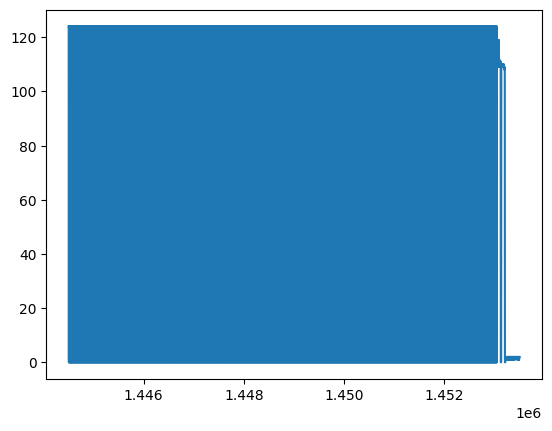

In [ ]:
plt.plot(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer'])

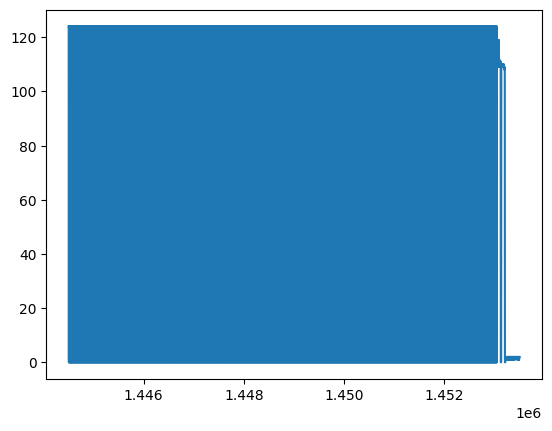

In [ ]:
plt.plot(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer'])

In [ ]:
len(df4[(df4['time'] >= '2014-08-01 18:00:00	') & (df4['time'] <= '2014-08-02 14:00:08')]['freezer'])

9001

### teste h20

In [ ]:
test = h20_sequence  # Remplacez par vos vraies données de test
test = torch.from_numpy(test)
test = test.unsqueeze(1)  # Ajouter une dimension de canal, donc shape devient (583, 1, 8000)
test = test.to(device).float()

In [ ]:
criterion2 = nn.MSELoss(reduction='none')

In [ ]:
# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon, mu, logvar = vae(test)

    # Calculer la perte de reconstruction
    recon_loss = criterion(x_recon, test)
    recon_loss_each_seq = criterion2(x_recon, test)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss)
    print(recon_loss_each_seq)


tensor(0.2127)
tensor([[[0.4073, 0.3462, 0.2872,  ..., 0.1381, 0.0999, 0.2806]],

        [[0.1735, 0.1287, 0.1007,  ..., 0.3610, 0.4694, 0.9691]],

        [[0.1098, 0.0764, 0.0610,  ..., 0.2428, 0.4379, 0.4230]],

        ...,

        [[0.0355, 0.0250, 0.0299,  ..., 0.1139, 0.0981, 0.2626]],

        [[0.0633, 0.0528, 0.0351,  ..., 0.1473, 0.1523, 0.4128]],

        [[0.1594, 0.1174, 0.0894,  ..., 0.5142, 0.4509, 0.8816]]])


In [ ]:
recon_loss_each_seq.shape

torch.Size([1104, 1, 4032])

In [ ]:
tensor_squeezed = recon_loss_each_seq.squeeze(1)

In [ ]:
tensor_squeezed.shape

torch.Size([1104, 4032])

In [ ]:
numpy_array = tensor_squeezed.numpy()
print(numpy_array.shape)

(1104, 4032)


In [ ]:
list_mean_normal =[]

for x in numpy_array:
    list_mean_normal.append(x.mean())

In [ ]:
list_mean_normal

[0.35756937,
 0.06587643,
 0.06912755,
 0.52667177,
 0.15093274,
 0.058075022,
 0.45205304,
 0.0585425,
 0.42405254,
 0.047145292,
 0.0598333,
 0.45757774,
 0.074262746,
 0.06379047,
 0.41707617,
 0.054630097,
 0.3658181,
 0.14699022,
 0.06754883,
 0.6825721,
 0.21644667,
 0.22846955,
 0.5443546,
 0.048172325,
 0.45998597,
 0.32745305,
 0.113186724,
 0.4092874,
 0.05341436,
 0.04354424,
 0.3805946,
 0.0731364,
 0.35158962,
 0.063456975,
 0.125744,
 0.34545496,
 0.06959021,
 0.06655209,
 0.37852126,
 0.31890383,
 0.4857951,
 0.08753716,
 0.054879747,
 0.41709942,
 0.06690466,
 0.04665432,
 0.3987823,
 0.16572368,
 0.04880937,
 0.34208938,
 0.27409896,
 0.3508241,
 0.057617247,
 0.074089736,
 0.40174726,
 0.07249867,
 0.05906295,
 0.61173403,
 0.039252352,
 0.36434352,
 0.13469543,
 0.043593224,
 0.37150043,
 0.052199174,
 0.04681998,
 0.331198,
 0.04864531,
 0.42568502,
 0.054411706,
 0.059693895,
 0.38785538,
 0.04716862,
 0.06159155,
 0.39912438,
 0.046331413,
 0.37130985,
 0.0483603,

### teste sur h20 annoté

In [ ]:
df4 = pd.read_csv('/Users/tchouar/code_stage/anomali_anotation/house20_anotated.csv')

In [ ]:
h20_anotated_scaled = data_normalization(df4, 'freezer')

In [ ]:
h20_anotated_sequence = split_and_pad_array(h20_anotated_scaled, 4032)

In [ ]:
test_data = h20_anotated_sequence  # Remplacez par vos vraies données de test
test_data = torch.from_numpy(test_data)
test_data = test_data.unsqueeze(1)  # Ajouter une dimension de canal, donc shape devient (583, 1, 8000)
test_data = test_data.to(device).float()

In [ ]:
# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon, mu, logvar = vae(test_data)

    # Calculer la perte de reconstruction
    recon_loss_anotated_df = criterion(x_recon, test_data)
    recon_loss_each_seq2 = criterion2(x_recon, test_data)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss)
    print(recon_loss_each_seq2)


tensor(0.2127)
tensor([[[0.3989, 0.3445, 0.2889,  ..., 0.1629, 0.1236, 0.3170]],

        [[0.1937, 0.1467, 0.1169,  ..., 0.3866, 0.5004, 1.0122]],

        [[0.1307, 0.0939, 0.0763,  ..., 0.2381, 0.4309, 0.3993]],

        ...,

        [[0.0781, 0.0951, 0.0605,  ..., 0.1737, 0.1501, 0.3605]],

        [[0.0778, 0.0572, 0.0538,  ..., 0.1580, 0.1286, 0.3092]],

        [[0.1031, 0.0691, 0.0446,  ..., 1.3823, 1.5396, 1.0565]]])


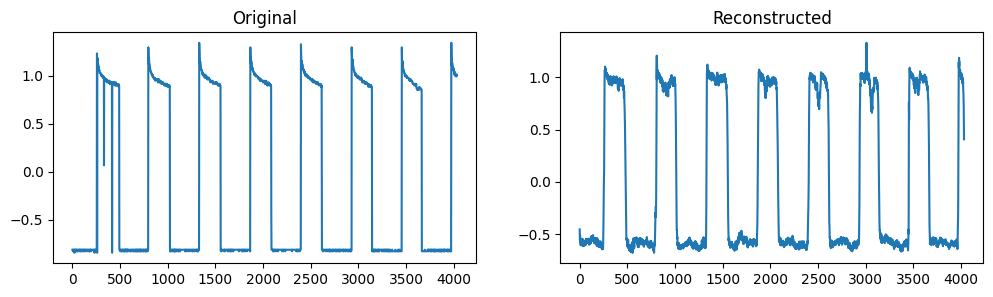

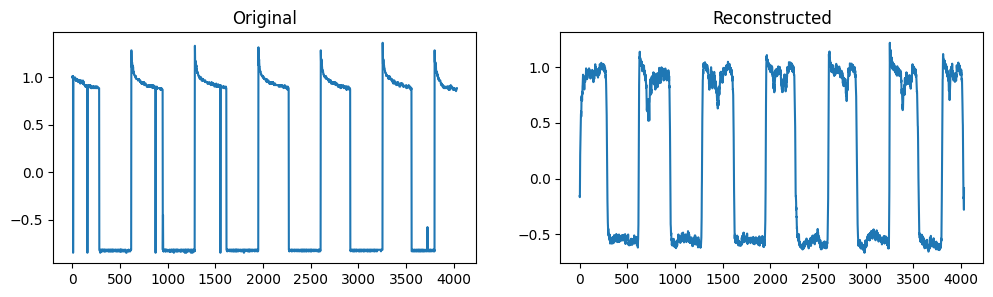

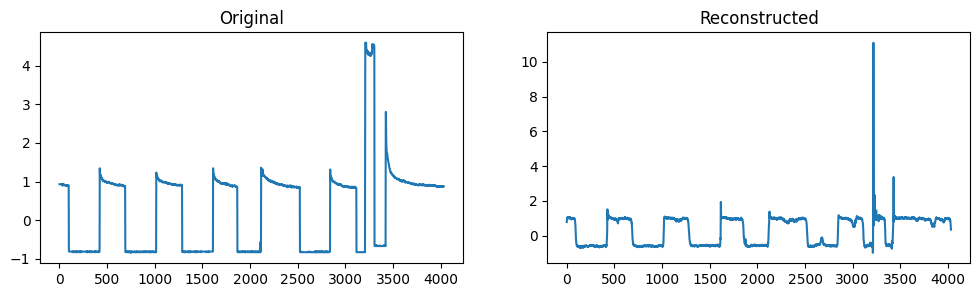

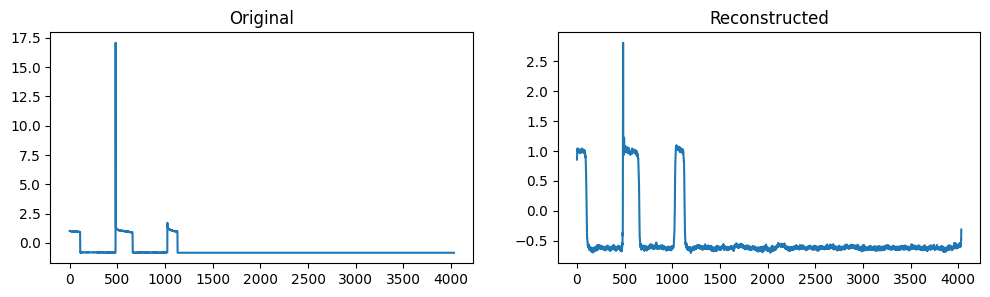

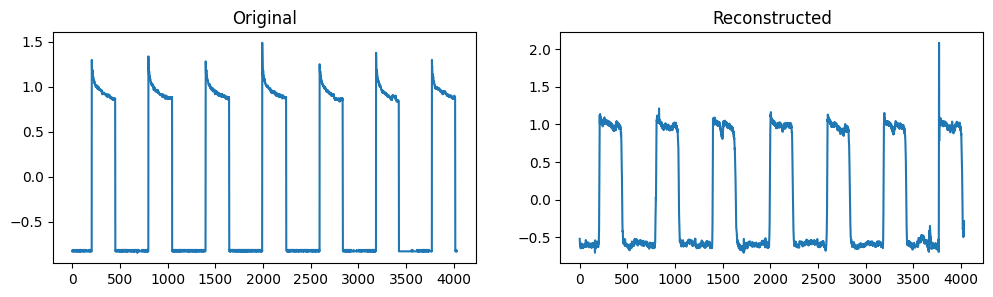

In [ ]:
# Sélectionner quelques exemples aléatoires
num_examples = 5
indices = torch.randint(0, test_data.size(0), (num_examples,))

for i, idx in enumerate(indices):
    original = test_data[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.plot(reconstructed)
    plt.title('Reconstructed')
    plt.show()

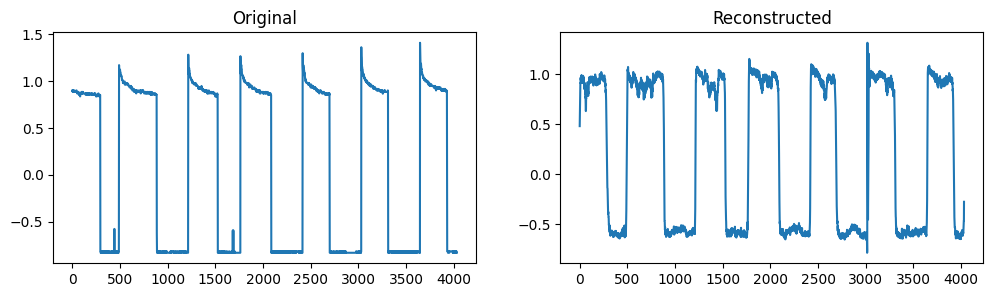

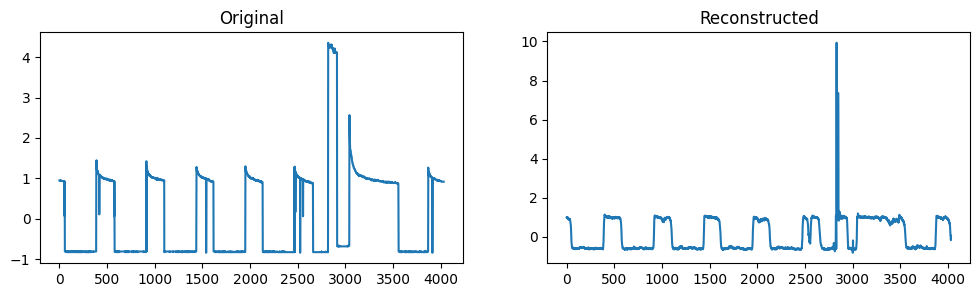

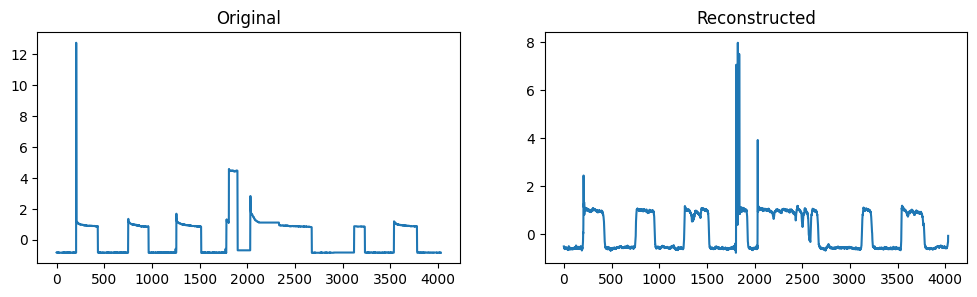

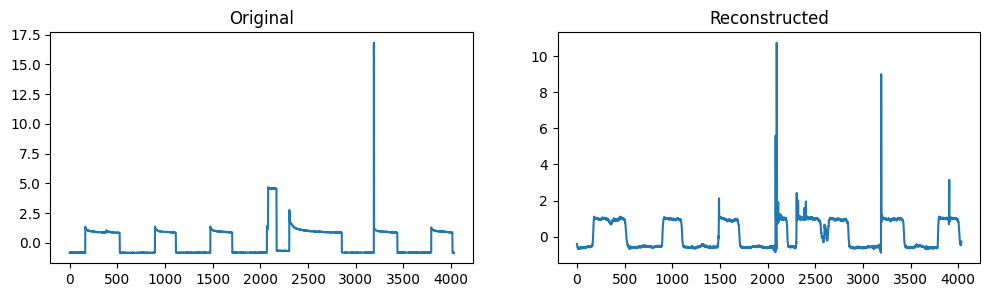

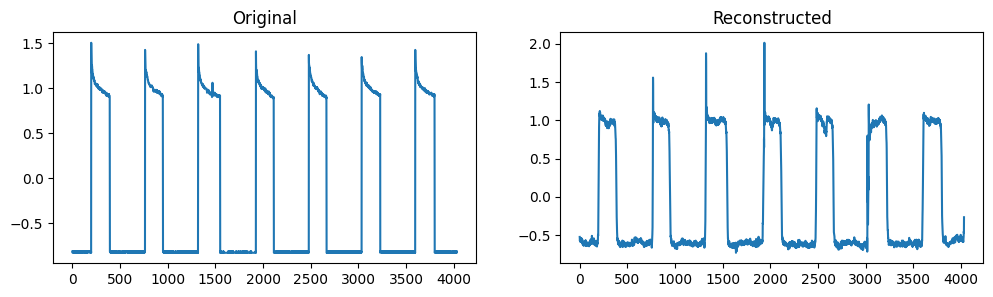

In [ ]:
# Sélectionner quelques exemples aléatoires
num_examples = 5
indices = torch.randint(0, test_data.size(0), (num_examples,))

for i, idx in enumerate(indices):
    original = test_data[idx].cpu().numpy().flatten()
    reconstructed = x_recon[idx].cpu().numpy().flatten()

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.plot(reconstructed)
    plt.title('Reconstructed')
    plt.show()

In [ ]:
tensor_squeezed2 = recon_loss_each_seq2.squeeze(1)

In [ ]:
numpy_array2 = tensor_squeezed2.numpy()
print(numpy_array2.shape)

(1159, 4032)


In [ ]:
list_mean_anotated =[]

for x in numpy_array2:
    list_mean_anotated.append(x.mean())

In [ ]:
len(list_mean_anotated), len(list_mean_normal)

(1159, 1104)

In [ ]:
1159 - 1104

55

In [ ]:
liste_copied =list_mean_normal.copy()
liste_copied.extend(([None] * 55))

In [ ]:
len(list_mean_anotated), len(liste_copied)

(1159, 1159)

In [ ]:
df = pd.DataFrame({
    'df_normal_consumption_MSE': liste_copied,
    'df_annotated_MSE': list_mean_anotated
})

In [ ]:
df.loc[10]

df_normal_consumption_MSE    0.059833
df_annotated_MSE             0.068665
Name: 10, dtype: float64

In [ ]:
df.head(100)

,df_normal_consumption_MSE,df_annotated_MSE
0,0.357569,0.357872
1,0.065876,0.074594
2,0.069128,0.075987
3,0.526672,0.528784
4,0.150933,0.160449
...,...,...
95,0.060018,0.067803
96,0.106572,0.111271
97,0.423890,0.424453
98,0.129763,0.134956


### test sur 2 séquences de 4032, anomaly

In [ ]:
with open('/Users/tchouar/code_stage/anomali_anotation/normal_consumption/VAE model freezer/seq_4032_anomaly1_freezer', 'rb') as fichier:
    # Désérialiser la liste
    anomaly1 = pickle.load(fichier)

In [ ]:
with open('/Users/tchouar/code_stage/anomali_anotation/normal_consumption/VAE model freezer/seq_4032_anomaly2_freezer', 'rb') as fichier:
    # Désérialiser la liste
    anomaly2 = pickle.load(fichier)

In [ ]:
len(anomaly1), len(anomaly2)

(9002, 4032)

In [ ]:
anomaly2 = anomaly2 / (np.max(anomaly2))
anomaly1 = anomaly1[:4032] /(np.max(anomaly1[:4032]))

In [ ]:
seq1_sequence = split_and_pad_array(anomaly1, 4032)
seq2_sequence = split_and_pad_array(anomaly2, 4032)

In [ ]:
type(seq1_sequence)

numpy.ndarray

In [ ]:
#eq1_test = np.array(anomaly1[:4032])  # Remplacez par vos vraies données de test
seq1_test = torch.from_numpy(seq1_sequence)
seq1_test = seq1_test.unsqueeze(1)  # Ajouter une dimension de canal, donc shape devient (583, 1, 8000)
seq1_test = seq1_test.to(device).float()

In [ ]:
seq1_test.shape

torch.Size([1, 1, 4032])

In [ ]:
# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon_seq1, mu, logvar = vae(seq1_test)

    # Calculer la perte de reconstruction
    #recon_loss = criterion(x_recon, seq_test)
    recon_loss_seq = criterion(x_recon_seq1, seq1_test)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss_seq)


tensor(0.2711)


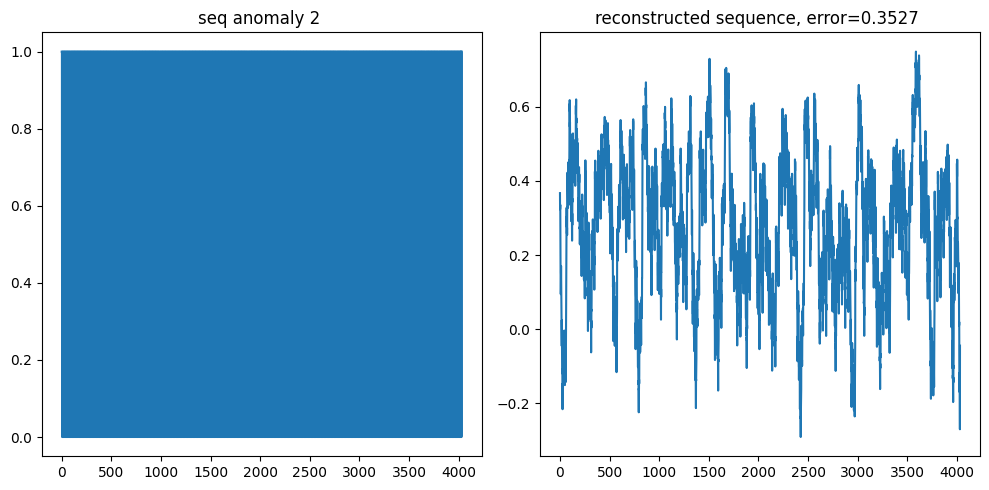

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(anomaly1)
plt.title('seq anomaly 2 ')

plt.subplot(1,2,2)
plt.plot(x_recon_seq1[0].cpu().numpy().flatten())
plt.title('reconstructed sequence, error=0.3527 ')

plt.tight_layout()

plt.show()

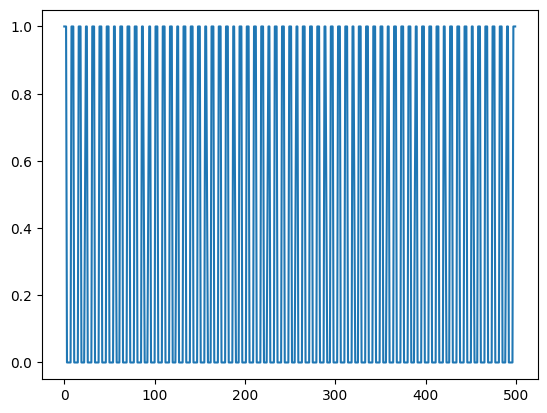

In [ ]:
plt.plot(anomaly1[:500])

In [ ]:
# revenir plutard a cette section

In [ ]:
#eq1_test = np.array(anomaly1[:4032])  # Remplacez par vos vraies données de test
seq2_test = torch.from_numpy(seq2_sequence)
seq2_test = seq2_test.unsqueeze(1)  # Ajouter une dimension de canal, donc shape devient (583, 1, 8000)
seq2_test = seq2_test.to(device).float()

In [ ]:
# Mettre le modèle en mode évaluation
vae.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon_seq2, mu, logvar = vae(seq2_test)

    # Calculer la perte de reconstruction
    #recon_loss = criterion(x_recon, seq_test)
    recon_loss_seq = criterion(x_recon_seq2, seq2_test)


    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    print(recon_loss_seq)


tensor(0.0192)


In [ ]:
x_recon_seq2.shape

torch.Size([1, 1, 4032])

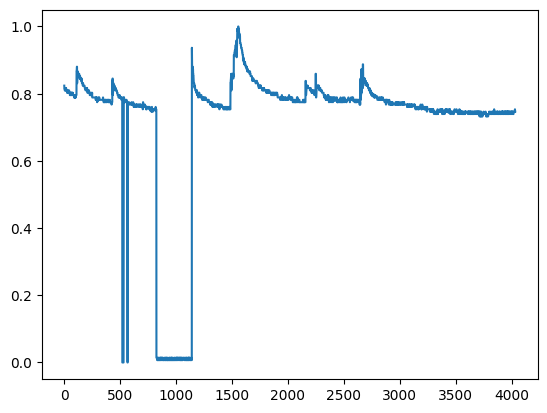

In [ ]:
plt.plot(anomaly2)

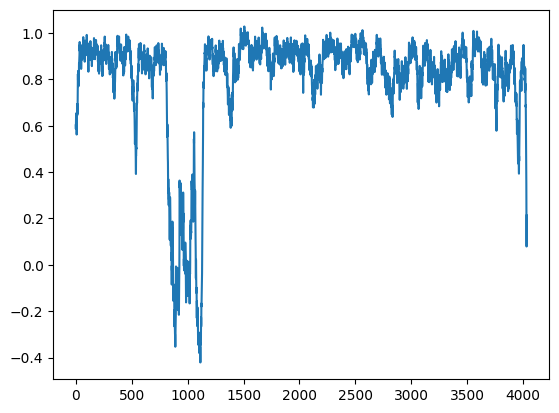

In [ ]:

plt.plot(x_recon_seq2[0].cpu().numpy().flatten())

In [ ]:
x_recon_seq2[0].cpu().numpy().flatten()

array([0.60187805, 0.58608913, 0.6200769 , ..., 0.23104553, 0.07902481,
       0.21292377], dtype=float32)

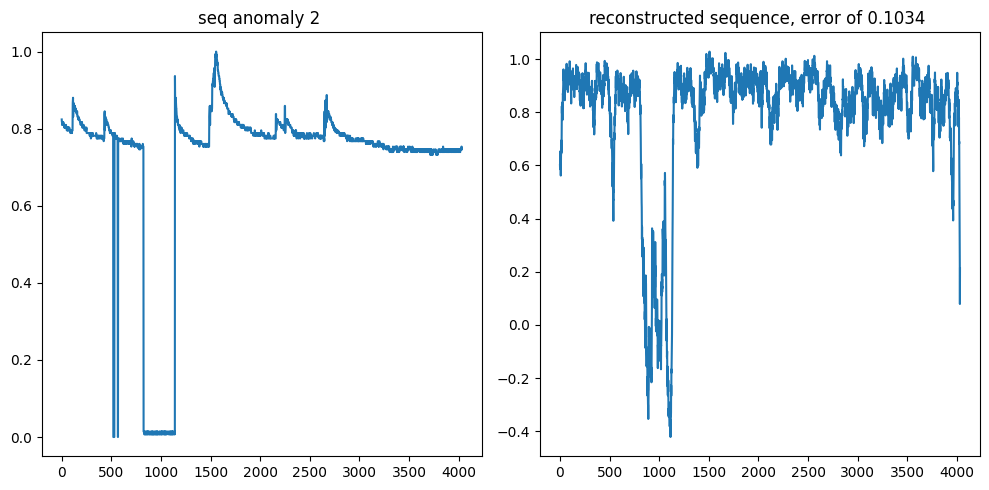

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(anomaly2)
plt.title('seq anomaly 2 ')

plt.subplot(1,2,2)
plt.plot(x_recon_seq2[0].cpu().numpy().flatten())
plt.title('reconstructed sequence, error of 0.1034 ')

plt.tight_layout()

plt.show()